In [1]:
%load_ext autoreload
%autoreload 2
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
from config.settings import *

In [3]:
import torch
from src.models.unet import UNet

unet = UNet(56,5)
I = torch.randn((1,1,1000,1000))
print(unet(I).shape)
print(list(unet.children()))

/home/kristian/mambaforge/envs/mitotem/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([1, 2, 632, 632])
[ModuleList(
  (0): EncoderBlock(
    (convblock): Sequential(
      (0): Conv2d(1, 56, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(56, 56, kernel_size=(5, 5), stride=(1, 1))
      (3): ReLU()
    )
    (poolblock): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): EncoderBlock(
    (convblock): Sequential(
      (0): Conv2d(56, 112, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(112, 112, kernel_size=(5, 5), stride=(1, 1))
      (3): ReLU()
    )
    (poolblock): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): EncoderBlock(
    (convblock): Sequential(
      (0): Conv2d(112, 224, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(224, 224, kernel_size=(5, 5), stride=(1, 1))
      (3): ReLU()
    )
    (poolblock): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): EncoderBlock(
 

In [7]:
from src.models.unet import find_next_valid_size
find_next_valid_size(1000,5,4)

(1000, 632)

### Overlap tile strategy test

0.19298934936523438


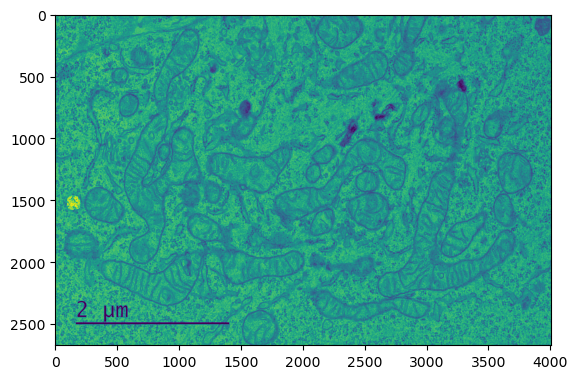

In [3]:
import torch
from torch.nn.functional import unfold, fold
import matplotlib.pyplot as plt
from src.data.loaders import MitoSemsegDataset
from torchvision.transforms.v2 import CenterCrop, ConvertDtype
from torchvision.transforms.v2.functional import pad
import time

dataset = MitoSemsegDataset(TRAIN_ROOT, transforms=ConvertDtype(torch.float32), indices=[81])
src, mask = dataset[0]
if src.ndim == 3:
    src = src.unsqueeze(0)

input_size = 1000
output_size = 632
model = CenterCrop(output_size)

k, s = input_size, output_size
h, w = src.shape[-2:]
extra_w = (1 + w//output_size)*output_size - w
extra_h = (1 + h//output_size)*output_size - h
p = (input_size-output_size)//2

use_fold = False

start = time.time()
src = pad(src, [p+extra_w, p, p, p+extra_h], padding_mode='reflect') # left, top, right,  bottom
if use_fold:
    # make a minibatch of patches
    patches = unfold(src, kernel_size=k, stride=s).permute(2,0,1).reshape(-1,1,k,k) 
    # do prediction on minibatch
    patches = model(patches).reshape(-1,1,s*s).permute(1,2,0)
    # fold patches back to full image
    dst = fold(patches, output_size=(h+extra_h,w+extra_w), kernel_size=s, stride=s)
else:
    L_w = 1 + ((src.shape[3] - k) // s)  # Number of horizontal overlap patches
    L_h = 1 + ((src.shape[2] - k) // s)  # Number of vertical overlap patches
    L = L_h * L_w  # Total number of patches

    # Arrange patches as minibatch
    patches_in = torch.empty((L, 1, k, k), dtype=torch.float32, device=src.device)
    for i in range(L_h):
        for j in range(L_w):
            patches_in[i * L_w + j, 0, :, :] = src[
                0, 0, i * s : i * s + k, j * s : j * s + k
            ]

    # Do prediction 8 overlap patches at a time
    patches_out = torch.empty((L, 1, s, s), dtype=torch.float32, device=src.device)
    for i in range(0,L,8):
        batch = patches_in[i : min(i + 8, L), :, :, :]
        patches_out[i : min(i + 8, L), :, :, :] = model(batch)

    # Gather patches back to a single image
    dst = torch.empty(
        (1, 1, h + extra_h, w + extra_w), dtype=torch.float32, device=src.device
    )
    for i in range(L_h):
        for j in range(L_w):
            dst[0, 0, i * s : (1 + i) * s, j * s : (1 + j) * s] = patches_out[
                i * L_w + j, 0, :, :
            ]

dst = dst[:,:,:-extra_h,extra_w:]

print(time.time()-start)

plt.imshow(dst.squeeze())
